In [1]:
"""
Script extracting wavenumbers, temperature, hot/cold status from temperature '.log' and raw spectra '.txt' files
"""

import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import math as m
import pandas as pd
import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import itertools
from scipy import interpolate

In [2]:
# VARIABLES
file_name = 'IC_raw_spectra_(2019_02_25_'

"""Sand"""
path_raw = '/Users/micol/Documents/Imperial/Year4/Master_Project/sand_outside' #path containing all raw spectra

In [3]:
#FUNCTIONS

def read_file(directory, filename, separator, rowstoskip, head='infer'):
    """
    Reads an external file and outputs it as a Pandas Dataframe
    Input: Directory, Filename (Strings)
    Output: Pandas Dataframe
    """
    path=os.path.join(directory, filename)
    dataset = pd.read_csv(path, header = head, sep=separator, skiprows=rowstoskip)
    
    return dataset


def planck(wavenumber, temperature): # T in Kelvin, wavenumber in cm^-1
    """
    Calculates spectral radiance of a black body at some wavenumber and temperature
    Input: wavenumber (units: cm^{-1}), and temperature T (units: Kelvin) - (Integers or Floats)
    Output: spectral radiance (units: W m^{-2} sr^{-1} cm^{-1}) - (Float)
    """
    h = 6.626e-34
    c = 3.0e+8
    k = 1.381e-23

    planck_a = 2*h*(c**2)
    planck_e = h*c/k
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/temperature)-1)

    return radiance


def read_raw_spectra(directory, filename):
    """
    Reads spectrum file and calculates the average of the 4 spectra
    Input: Directory, Filename (Strings)
    Output: average_spectrum (NumPy Array)
    """
    file_data = read_file(path_raw, filename, separator='  ', rowstoskip=5, head=None)
    spectrum1 = file_data[1].values
    spectrum2 = file_data[2].values
    spectrum3 = file_data[3].values
    spectrum4 = file_data[4].values
    
    return spectrum1,spectrum2,spectrum3,spectrum4

In [4]:
# CODE

#create list of file paths starting with file_name from 'path_raw' directory
measurements = len(glob.glob(path_raw + '/'+ file_name + '*')) #filepaths of all 'IC_raw_spectra' files
m_numbers = list(range(measurements)) #list of file name endings (integers)

for i in m_numbers:
    #checks that files have associated temperature measurements, and removes the files if not
    temp_check = read_file(path_raw, file_name + '{0:03}'.format(i) + '.txt', separator=',', rowstoskip=None, head=None).iloc[1,0]
    temp_check_float = float(temp_check.split()[0])
    if temp_check_float == 0.0:
        m_numbers.pop(i)

files = [file_name + '{0:03}'.format(num) + '.txt' for num in m_numbers][:-2] #final list of strings of file names, in order

In [5]:
columns_ = ['RT0','RT1','RT2','Dummy','RT3','RT4','HBB_temp','CBB_temp','Time', 'Orientation'] #columns for Pandas DataFrame

read_temps = []

for i in np.arange(0,len(files)):
    #Go through files and retrieve temperatures and orientations of spectra
    read_temps.append( read_file(path_raw, files[i], separator=',', rowstoskip=None, head=None).iloc[1:5,0].str.split() )
    read_temps_flat = list(itertools.chain(*read_temps)) #flatten read_temps_i

times_temps = pd.DataFrame(read_temps_flat, columns = columns_)

In [6]:
#times_temps.drop(['Dummy'], axis = 1, inplace = True, errors = 'ignore')
times_temps['hc'] = np.nan #add empty 'hc' column

times_temps.loc[times_temps['Orientation'] == '270', 'hc'] = 'h'             #If 'Orientation'=270 degrees from nadir, then facing HBB
times_temps.loc[times_temps['Orientation'] == '225', 'hc'] = 'c'             #facing CBB
times_temps.loc[times_temps['Orientation'] == '20', 'hc'] = 'sand'           #sand view at 20 degrees from nadir
times_temps.loc[times_temps['Orientation'] == '160', 'hc'] = 'sky_sand'      #sky view for sand measurement
times_temps.loc[times_temps['Orientation'] == '55', 'hc'] = 'water'          #water view at 55 degrees from nadir
times_temps.loc[times_temps['Orientation'] == '125', 'hc'] = 'sky_water'     #sky view for water measurement

#columns_.pop(columns_.index('Time')) #Remove b from list
#columns_.pop(columns_.index('Orientation'))
#times_temps = times_temps[['Time']+columns_] #Create new dataframe with columns in the order you want

In [7]:
times_temps[700:730]

,RT0,RT1,RT2,Dummy,RT3,RT4,HBB_temp,CBB_temp,Time,Orientation,hc
700,21.820,21.150,21.330,850.000,22.350,22.440,69.970,28.810,58990,270,h
701,21.810,21.230,21.400,850.000,22.470,22.460,69.970,28.790,59014,270,h
702,21.930,21.280,21.430,850.000,22.670,22.820,69.960,28.790,59039,225,c
703,21.970,21.320,21.460,850.000,22.740,23.010,69.950,28.800,59064,225,c
704,21.970,21.290,21.440,850.000,22.710,22.920,69.960,28.810,59094,225,c
705,21.980,21.270,21.420,850.000,22.400,22.300,69.950,28.820,59119,225,c
706,21.970,21.240,21.400,850.000,22.620,22.310,69.960,28.820,59143,225,c
707,22.000,21.250,21.460,850.000,22.060,22.130,69.960,28.820,59166,225,c
708,21.670,21.170,21.460,850.000,22.290,22.300,69.970,28.810,59197,225,c
709,21.610,21.060,21.170,850.000,21.250,21.180,69.960,28.810,59220,225,c


In [8]:
water_ind = times_temps.index[times_temps['hc']=='sky_water'].tolist()


In [9]:
water1cold, water2cold, water3cold, water4cold = read_raw_spectra(path_raw, 'IC_raw_spectra_(2019_02_25_'+'180.txt')
water1hot, water2hot, water3hot, water4hot = read_raw_spectra(path_raw, 'IC_raw_spectra_(2019_02_25_'+'190.txt')

#com,pare to spectra before and after
water1coldbefore, water2coldbefore, water3coldbefore, water4coldbefore = read_raw_spectra(path_raw, 'IC_raw_spectra_(2019_02_25_'+'138.txt')
water1hotafter, water2hotafter, water3hotafter, water4hotafter = read_raw_spectra(path_raw, 'IC_raw_spectra_(2019_02_25_'+'205.txt')

spec_cold = water2cold
spec_hot = water3hot 

spec_cold_before = water2coldbefore
spec_hot_after = water2hotafter 

wavenums = read_file(path_raw, files[0], separator='  ', rowstoskip=5, head=None)[0].values

/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


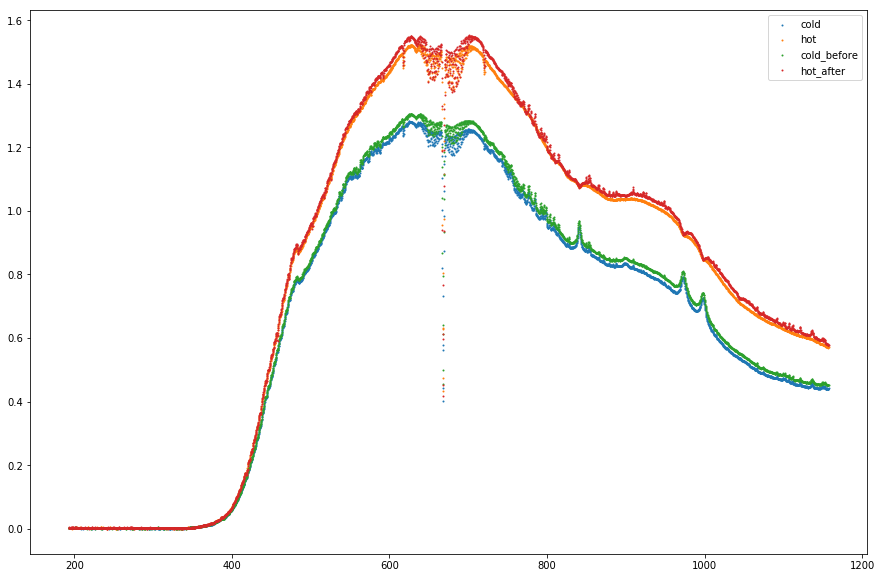

In [10]:
plt.figure(figsize=(15,10))
plt.scatter(wavenums, spec_cold, s=1)
plt.scatter(wavenums, spec_hot, s=1)
plt.scatter(wavenums, spec_cold_before, s=1)
plt.scatter(wavenums, spec_hot_after, s=1)
plt.legend(['cold', 'hot', 'cold_before', 'hot_after'])

plt.show()

/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


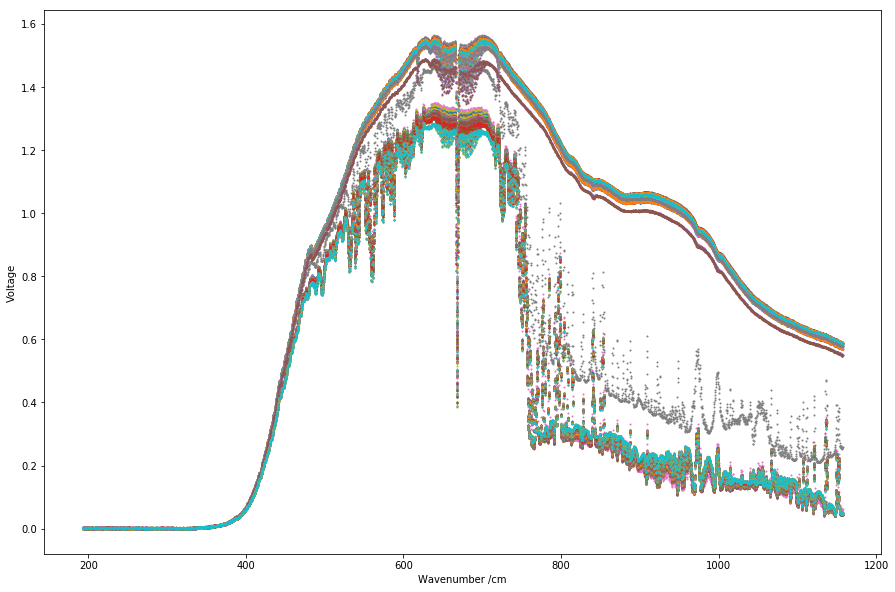

In [12]:
plt.figure(figsize=(15,10))

for index in water_ind:
    water_spec = read_raw_spectra(path_raw, files[int(np.floor(index/4))])[index%4]
    plt.scatter(wavenums, water_spec, s=1)
    plt.xlabel('Wavenumber /cm')
    plt.ylabel('Voltage')
    
plt.show()

This looks wrong!!

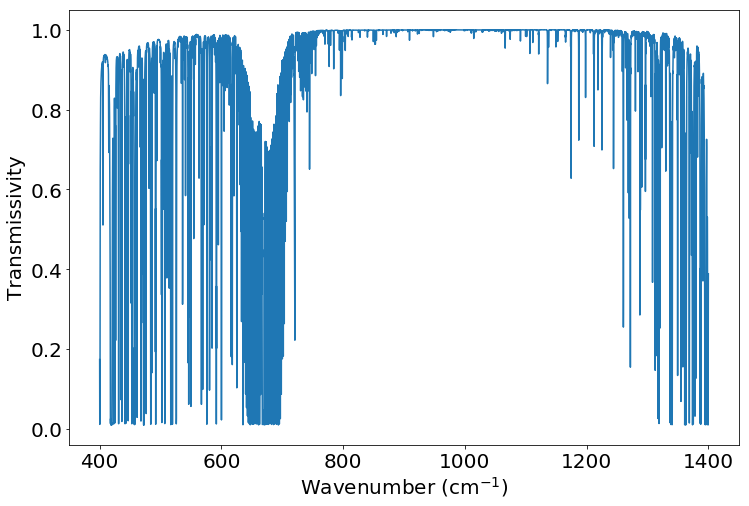

In [14]:
# get tau from Laura's files - need to interpolate for time and wavenum

file_path_tau = "/Users/micol/Documents/Imperial/Year4/Master_Project/sand_outside/Laura_simulations"
transmission = np.loadtxt(file_path_tau + '/1165_5460.txt')

trans_wn = []
trans_val = []

for i in np.arange(transmission.shape[0]):
    if transmission[i][1] > 0.01:
        trans_wn.append(transmission[i][0])
        trans_val.append(transmission[i][1])
        
f_trans = interpolate.interp1d(trans_wn, trans_val)

wavenums_t = np.arange(400,1400,0.1)
trans = []

for i in wavenums_t:
    trans.append(f_trans(i))
    
    
plt.figure(figsize=(12,8))
plt.plot(wavenums_t, trans)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.ylabel('Transmissivity', fontsize=20)
plt.tick_params(labelsize=20)
plt.show()